### Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# tSNE1 : Conceptual: Input similarities

Load the data dedicated for this and the next example from Moodle. Plot the data.

(a) Program the calculation of the similarity S in the input space using a constant σi or all i as described in the lecture.

(b) Change the value of σi : describe the effect on the similarities (of course graphically)

### Loading the data

In [3]:
dataset = pd.read_csv('dataForPerplexity.csv')

dataset.head()

x        y
0 -2.17460  0.79726
1  0.14461 -0.44250
2  0.66903 -0.62909
3 -0.84883  1.53380
4 -0.05709  2.73350

### Scatterplot

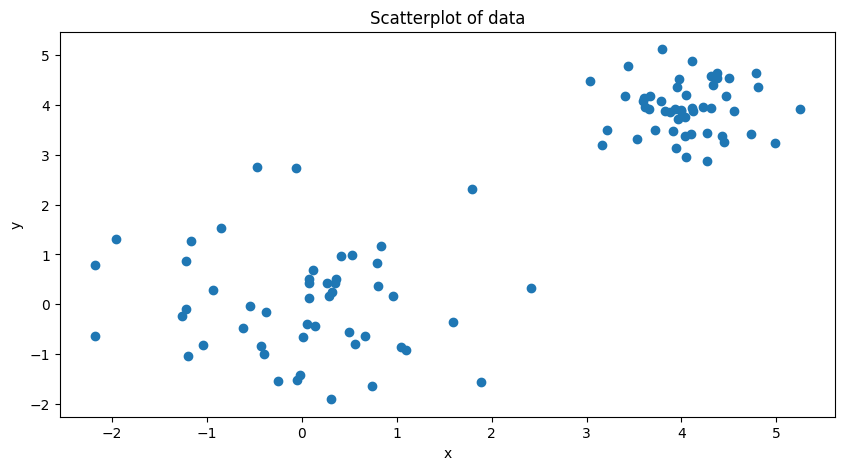

In [4]:
plt.figure(figsize=(10, 5))
plt.title("Scatterplot of data")
plt.scatter(dataset['x'], dataset['y'])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Calculation of similarities

In [ ]:
# function to compute the similarity matrix -> based on the slides of the lecture
def compute_similarity_matrix(X: pd.DataFrame, sigma: float) -> np.ndarray:
    n = X.shape[0] #number of instances
    S = np.zeros((n, n))  # similarity matrix

    for i in range(n):
        for j in range(n):
            dist = np.linalg.norm(X[i] - X[j]) ** 2  # squared Euclidean distance
            S[i, j] = np.exp(-dist / (2 * sigma**2)) # similarity computation

    # normalize each row
    S = S / np.sum(S, axis=1, keepdims=True)

    # symmetrize the matrix
    S = (S + S.T) / (2 * n)

    # return the similarity matrix
    return S

# function to visualize the similarity matrix
def visualize_similarity(S: np.array, title: str) -> None:
    plt.figure(figsize=(8, 6))
    plt.imshow(S, cmap='hot', interpolation='nearest')
    plt.title(title)
    plt.xlabel("Instances")
    plt.ylabel("Instances")
    plt.colorbar()
    plt.show()


### Similarity matrix for constant sigma

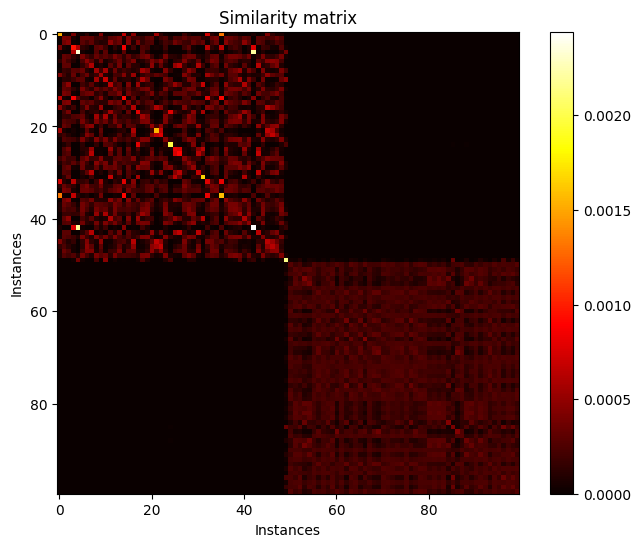

In [8]:
sigma = 1
S = compute_similarity_matrix(dataset[['x', 'y']].values, sigma)

visualize_similarity(S, 'Similarity matrix')

#### Obervations
- each entry represent the similarity Sij
- the brighter the cel the bigger the similarity is
- with 𝜎 = 1 the Gaussian kernel is tuned to focus on local neighborhoods :
    - close neighbors (small distance): Higher similarity values (brighter cells).
    - distant neighbors (large distance): Very low similarity values (darker cells).
- the top-left block corresponds to a cluster of points that are very similar to one another.
- the bottom-right block indicates another cluster.

### Test similarity matrix for different sigma

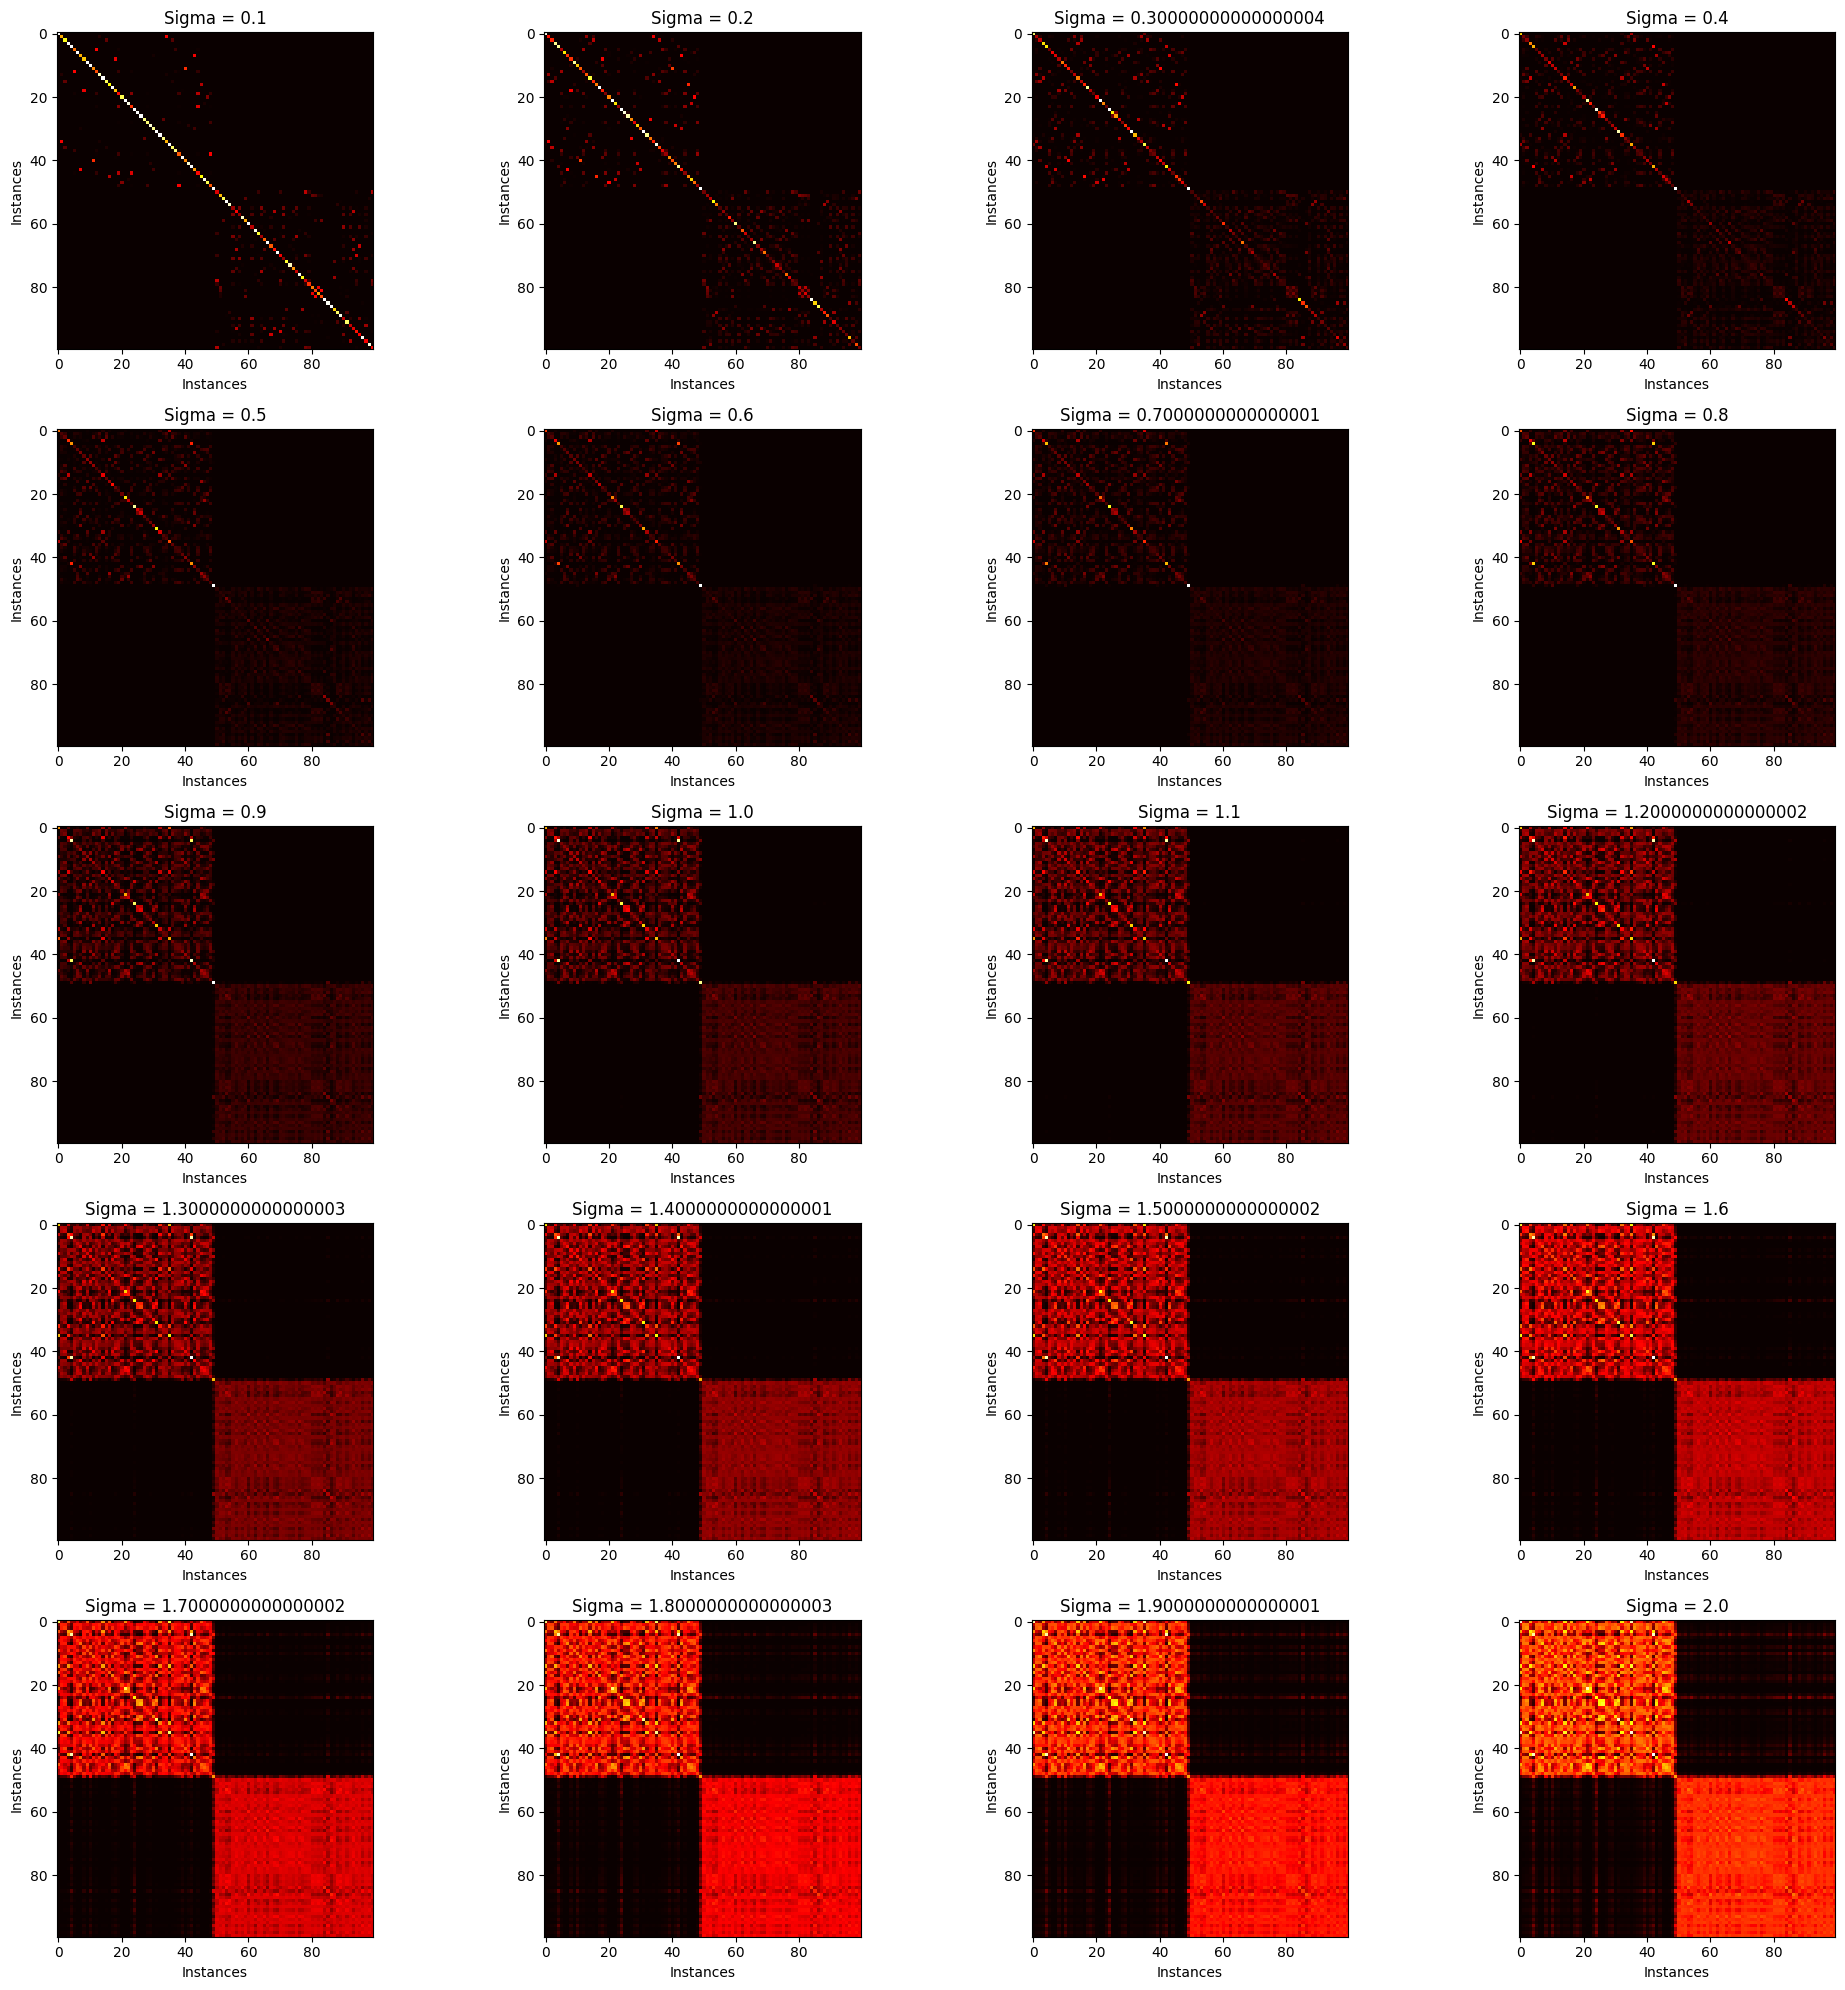

In [14]:
# different values of sigma
sigmas_values = np.arange(0.1, 2.1, 0.1)

# function to add plot to subplot
def add_plot_to_subplot(sigma: float, ax: plt.Axes) -> None:
    S = compute_similarity_matrix(dataset[['x', 'y']].values, sigma)
    ax.imshow(S, cmap='hot', interpolation='nearest')
    ax.set_title(f'Sigma = {sigma}')
    ax.set_xlabel("Instances")
    ax.set_ylabel("Instances")

# plot the similarity matrix for different values of sigma
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
for i, sigma in enumerate(sigmas_values):
    add_plot_to_subplot(sigma, axs[i//4, i%4])
plt.tight_layout()


#### Diagonal Dominance:
- Across all matrices, the diagonal remains the brightest because the self-similarity \( S_{ii} \) is always 1.
- This is a property of the Gaussian kernel where every data point is most similar to itself.

*Symmetry of the Matrices:*
- All matrices are symmetric, which is expected because the similarity \( S_{ij} \) between two points is identical in both directions (\( S_{ij} = S_{ji} \)).
- This symmetry ensures balanced representation of similarities, which is crucial for methods like t-SNE.

#### Effect of \( \sigma \):
*Small \( \sigma \):*
- With \( \sigma = 0.1 \) to \( \sigma = 0.5 \), the similarities are extremely localized.
- Only very close neighbors exhibit significant similarity (bright yellow), while the rest of the matrix is dark (low similarity values).
- This highlights the dominance of local structure with small \( \sigma \).

*### *Intermediate \( \sigma \):*
- Around \( \sigma = 1.0 \), the similarities spread further, capturing medium-range relationships in addition to immediate neighbors.
- Clusters of similar points (bright diagonal blocks) are still prominent but more points now share significant similarities.

*Large \( \sigma \):*
- With \( \sigma > 1.5 \), the similarities become more global.
- The matrix becomes brighter overall, with even distant points exhibiting non-negligible similarity.
- However, excessive values of \( \sigma \) (e.g., \( \sigma = 2.0 \)) dilute the local structure, and the matrix becomes almost uniformly bright.

#### Cluster Representation:
- Bright blocks along the diagonal indicate clusters of similar points.
- For smaller \( \sigma \), these blocks are highly distinct and localized, representing clear separation between clusters.
- As \( \sigma \) increases, these blocks blur, representing increasing inter-cluster similarities.


# tSNE2 : Conceptual: Algorithmic determination of the local scale

Consider the same data as before and the results from exercise 1

(a) Write a program that determines the entropy of the computed similarity values

(b) Write a binary search that determines the local scale σi for any specified single data point.

#### a) Write a program that determines the entropy of the computed similarity values

In [35]:
# function to calculate entropy
def calculate_entropy(similarity_matrix: np.ndarray) -> float:
    similarity_matrix = np.maximum(similarity_matrix, 1e-12)  # avoid log(0)
    entropies = -np.sum(similarity_matrix * np.log2(similarity_matrix), axis=1)
    return entropies # array of entropies

entropies = calculate_entropy(S)
entropies

array([0.08954008, 0.13592016, 0.12809564, 0.10733119, 0.08521593,
       0.13543234, 0.128962  , 0.11390684, 0.12095994, 0.12463047,
       0.11051992, 0.11457916, 0.13448964, 0.13320655, 0.10744161,
       0.13182169, 0.11813688, 0.10611502, 0.11908865, 0.13268918,
       0.12249729, 0.08589651, 0.1050322 , 0.1305439 , 0.08246998,
       0.10333498, 0.09756105, 0.13302002, 0.12909039, 0.12345598,
       0.1080003 , 0.08351108, 0.11288837, 0.13519805, 0.13657287,
       0.08939569, 0.12714093, 0.13685837, 0.13387477, 0.11813533,
       0.1167178 , 0.1253672 , 0.08379368, 0.11048869, 0.13176564,
       0.11619243, 0.11373901, 0.12607042, 0.13270821, 0.08432066,
       0.12702511, 0.12587077, 0.12650711, 0.10485037, 0.1093396 ,
       0.13266586, 0.12142522, 0.13291719, 0.12630336, 0.12778039,
       0.10938066, 0.13271687, 0.1102482 , 0.12162609, 0.13223296,
       0.11944606, 0.10560218, 0.13103429, 0.11867967, 0.11298443,
       0.12839702, 0.13285176, 0.13109159, 0.12692929, 0.12551

#### b) Write a binary search that determines the local scale sigma for any specified single data point

In [37]:
def binary_search_sigma(x_i, X, perplexity, tol=1e-5, max_iter=50):
    # compute pairwise squared distances between x_i and all points in X
    distances = np.linalg.norm(X - x_i, axis=1)**2

    # target entropy
    target_entropy = np.log(perplexity)

    # initialize binary search bounds
    sigma_min = 1e-5
    sigma_max = 50.0
    sigma = 1.0  # starting sigma

    for iteration in range(max_iter):
        # cmpute similarities with current sigma
        similarities = np.exp(-distances / (2 * sigma**2))
        similarities[distances == 0] = 0  # ignore the point itself
        probabilities = similarities / np.sum(similarities)  # normalize to get probabilities

        # compute entropy
        entropy = -np.sum(probabilities * np.log(probabilities + 1e-10))  # Avoid log(0)

        # check closenest to target entropy
        if np.abs(entropy - target_entropy) < tol:
            break

        # adjust the sigma value
        if entropy > target_entropy:
            sigma_max = sigma
        else:
            sigma_min = sigma

        # update sigma
        sigma = (sigma_min + sigma_max) / 2

    return sigma

In [39]:
X = dataset[['x', 'y']].values

# calculating sigmas for different points
sigmas = []
for i in range(10):
    x_i = X[i]
    optimal_sigma = binary_search_sigma(x_i, X, perplexity=30)
    print(f"Optimal sigma for the {i+1} point: {np.round(optimal_sigma,4)}")
    sigmas.append(optimal_sigma)


print("Sigmas for all points: ", np.round(sigmas,4))

Optimal sigma for the 1 point: 1.2833
Optimal sigma for the 2 point: 0.6546
Optimal sigma for the 3 point: 0.7415
Optimal sigma for the 4 point: 1.019
Optimal sigma for the 5 point: 1.2555
Optimal sigma for the 6 point: 0.73
Optimal sigma for the 7 point: 0.75
Optimal sigma for the 8 point: 0.9537
Optimal sigma for the 9 point: 0.918
Optimal sigma for the 10 point: 0.7767
Sigmas for all points:  [1.2833 0.6546 0.7415 1.019  1.2555 0.73   0.75   0.9537 0.918  0.7767]


# tSNE3 :  Conceptual: Gradient descent in 1-D.

Consider the following loss function
loss(x) = x^5 - 5x^4 + 5x^3 + 5x^2 - 6x

(a) Program the one-dimensional gradient descent algorithm (using the exact derivative)

(b) The loss function has two local minima. Find them using your gradient descent function. Experimentally determine the set of starting points x0 that lead to the first local minimum and the set of starting points x0 that lead to the second local minimum.


In [266]:
class GradientDescent:
    def __init__(self, function, derivative, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        self.function = function
        self.derivative = derivative
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance

    def caclulate_gradient_step(self, x):
        gradiendt = self.derivative(x)
        x_next = x - self.learning_rate * gradiendt

        return x_next

    def minimize(self, starting_point, verbose=True):
        x = starting_point
        trace = [x]  # Track the path of x values

        for i in range(self.max_iterations):

            # calculate the gradient step
            x_next = self.caclulate_gradient_step(x)
            trace.append(x_next)

            # Check for convergence
            if abs(x_next - x) < self.tolerance and verbose:
                print(f"Converged after {i} iterations.")
                break

            x = x_next

        return x, trace

    def plot_trace(self, trace):
        x_vals = np.linspace(-2, 5, 500)
        y_vals = [self.function(x) for x in x_vals]

        # plot the function
        plt.figure(figsize=(10, 6))
        plt.plot(x_vals, y_vals, label="Loss Function")

        # plot the trace
        trace_y = [self.function(x) for x in trace]
        plt.scatter(trace, trace_y, color="red", label="Trace to Minimum")
        plt.plot(trace, trace_y, color="red", linestyle="--")

        # highlight the starting point and the minimum
        plt.scatter(trace[0], self.function(trace[0]), color="blue", label="Starting Point", zorder=5)
        plt.scatter(trace[-1], self.function(trace[-1]), color="green", label="Minimum", zorder=5)

        plt.title("Gradient Descent Trace")
        plt.xlabel("x")
        plt.ylabel("Loss(x)")
        plt.legend()
        plt.grid(True)
        plt.show()



Converged after 84 iterations.
Local minimum at: 0.45609481472391833


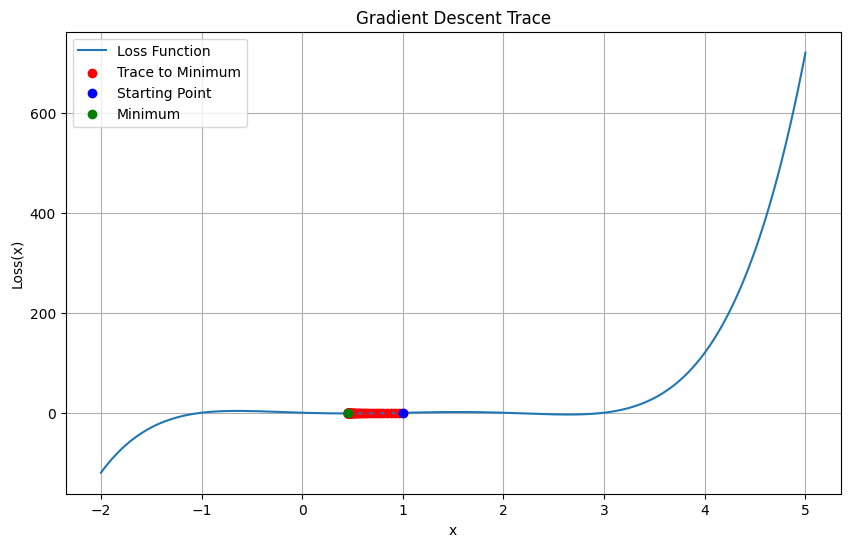

In [267]:
# define loss function and derivative
def loss(x):
    return x**5 - 5*x**4 + 5*x**3 + 5*x**2 - 6*x

def loss_derivative(x):
    return 5*x**4 - 20*x**3 + 15*x**2 + 10*x - 6

# initialize gradient
gd = GradientDescent(
    function=loss,
    derivative=loss_derivative,
    learning_rate=0.01,
    max_iterations=1000,
    tolerance=1e-6
)

# Example: Start gradient descent from a point and plot the trace
starting_point = 1  # Change this to experiment with different starting points
minimum, trace = gd.minimize(starting_point)
print(f"Local minimum at: {minimum}")

# Plot the trace to the minimum
gd.plot_trace(trace)

Converged after 23 iterations.
Local minimum at: 2.6444308359413817


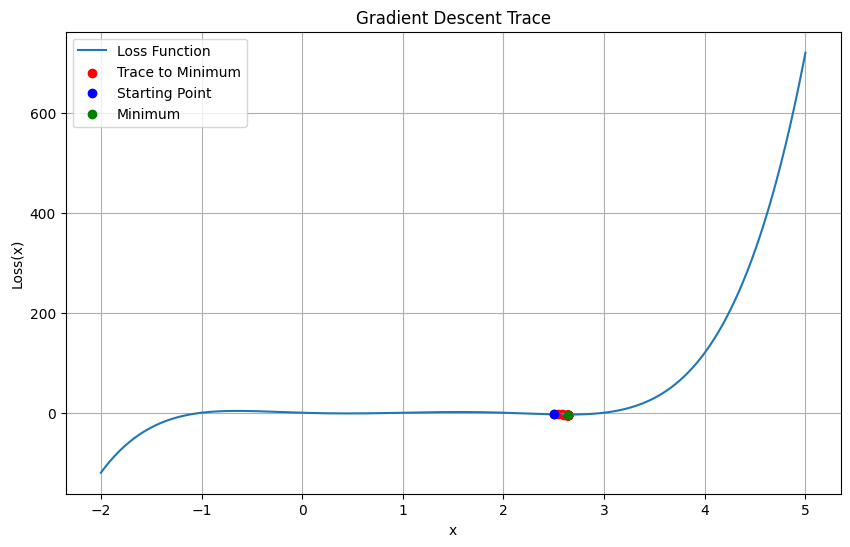

In [268]:
gd = GradientDescent(
    function=loss,
    derivative=loss_derivative,
    learning_rate=0.01,
    max_iterations=100,
    tolerance=1e-6
)


starting_point = 2.5
minimum, trace = gd.minimize(starting_point)
print(f"Local minimum at: {minimum}")

gd.plot_trace(trace)

C:\Users\barte\AppData\Local\Temp\ipykernel_16232\3723775193.py:6: RuntimeWarning: overflow encountered in scalar power
  return 5*x**4 - 20*x**3 + 15*x**2 + 10*x - 6
C:\Users\barte\AppData\Local\Temp\ipykernel_16232\3723775193.py:6: RuntimeWarning: invalid value encountered in scalar add
  return 5*x**4 - 20*x**3 + 15*x**2 + 10*x - 6


Starting points that lead to the first minimum around 0.46:  [np.float64(-0.6000000000000001), np.float64(-0.5000000000000001), np.float64(-0.40000000000000013), np.float64(-0.30000000000000016), np.float64(-0.20000000000000018), np.float64(-0.1000000000000002), np.float64(-2.220446049250313e-16), np.float64(0.09999999999999964), np.float64(0.19999999999999973), np.float64(0.2999999999999998), np.float64(0.3999999999999997), np.float64(0.49999999999999956), np.float64(0.5999999999999996), np.float64(0.6999999999999997), np.float64(0.7999999999999996), np.float64(0.8999999999999995), np.float64(0.9999999999999996), np.float64(1.0999999999999996), np.float64(1.1999999999999993), np.float64(1.2999999999999994), np.float64(1.3999999999999995), np.float64(1.4999999999999996), np.float64(3.999999999999999)]
Starting points that lead to the second minimum around 1.46:  [np.float64(1.5999999999999996), np.float64(1.6999999999999993), np.float64(1.7999999999999994), np.float64(1.899999999999999

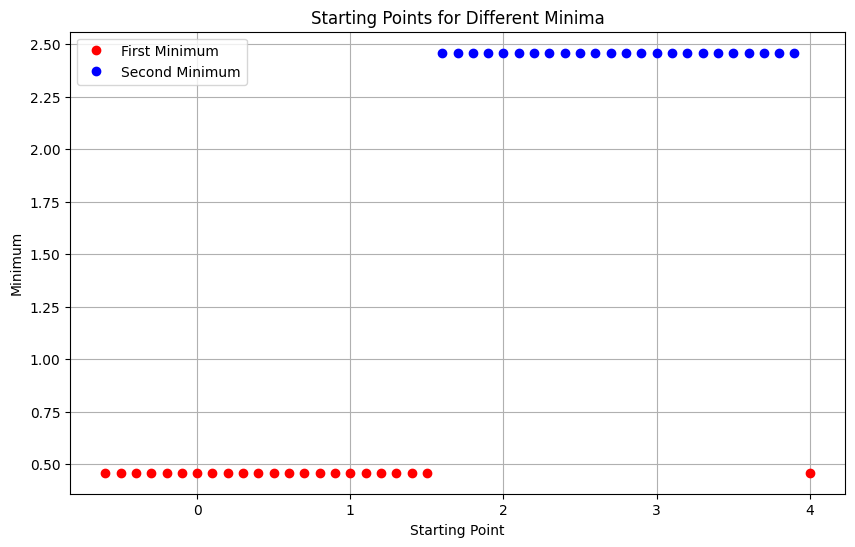

In [269]:
set_of_x = np.arange(-1, 4.1 ,0.1)

minimas = {}
for x in set_of_x:
    # caclulate the minimum for each x
    minimum, _ = gd.minimize(x, verbose=False)
    # store the minimum for starting point x
    minimas[x] = minimum

# get all starting points that lead to the first minimum around 0.46
first_minimum = [k for k, v in minimas.items() if 0.45 < v < 0.47]
print("Starting points that lead to the first minimum around 0.46: ", first_minimum)

# get all starting points that lead to the second minimum around 2.46
second_minimum = [k for k, v in minimas.items() if 2.4 < v]
print("Starting points that lead to the second minimum around 1.46: ", second_minimum)

# plot point belonging to each minimum
plt.figure(figsize=(10, 6))
plt.plot(first_minimum, [0.46]*len(first_minimum), 'ro', label="First Minimum")
plt.plot(second_minimum, [2.46]*len(second_minimum), 'bo', label="Second Minimum")
plt.title("Starting Points for Different Minima")
plt.xlabel("Starting Point")
plt.ylabel("Minimum")
plt.legend()
plt.grid(True)


# tSNE4 : Balls data


(a) “Reduce” the dimension of the balls data to 2 dimensions using tSNE. Plot the result.

(b) Reduce the dimension of the balls data to 1 dimension and plot the result.

(c) Vary the perplexity such that it is too low and too high, respectively. What happens when the perplexity is set too low? What happens when the perplexity is set too high?

In [270]:
# load dataset
balls = pd.read_csv('dataBalls.csv')
balls.head()

x         y
0 -0.202969 -1.520712
1 -0.545900 -2.165577
2  0.347952 -2.267513
3 -0.039389 -2.429920
4 -0.130040 -2.202356

#### a)

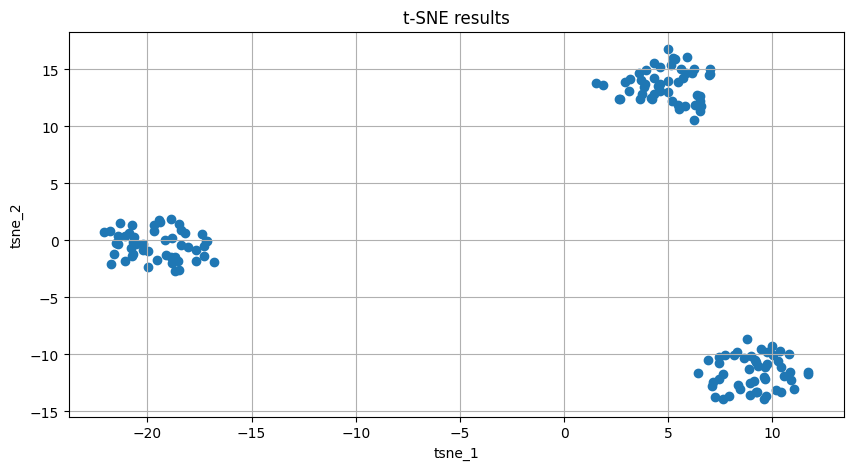

In [277]:
tnse_2_dim = TSNE(n_components=2, init='random', random_state=42, learning_rate='auto')
tnse_results = tnse_2_dim.fit_transform(balls)

# plot the t-SNE results
tse_result_df = pd.DataFrame(tnse_results, columns=['x', 'y'])
plt.figure(figsize=(10, 5))
plt.title("t-SNE results")
plt.scatter(tse_result_df['x'], tse_result_df['y'])
plt.xlabel("tsne_1")
plt.ylabel("tsne_2")
plt.title("t-SNE results")
plt.grid(True)


#### b)

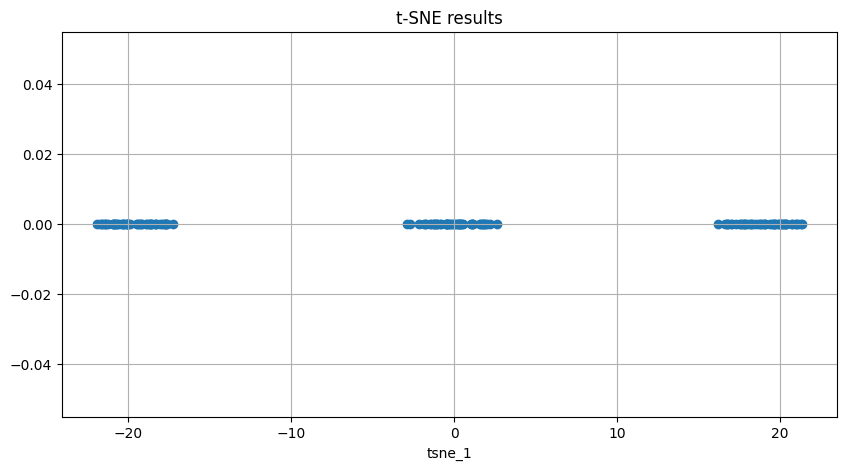

In [279]:
tnse_1_dim = TSNE(n_components=1, init='random', random_state=42, learning_rate='auto')
tnse_results = tnse_1_dim.fit_transform(balls)

# plot the t-SNE results
tse_result_df = pd.DataFrame(tnse_results, columns=['x'])
plt.figure(figsize=(10, 5))
plt.title("t-SNE results")
plt.scatter(tse_result_df['x'], np.zeros_like(tse_result_df['x']))
plt.xlabel("tsne_1")
plt.title("t-SNE results")
plt.grid(True)

#### c)

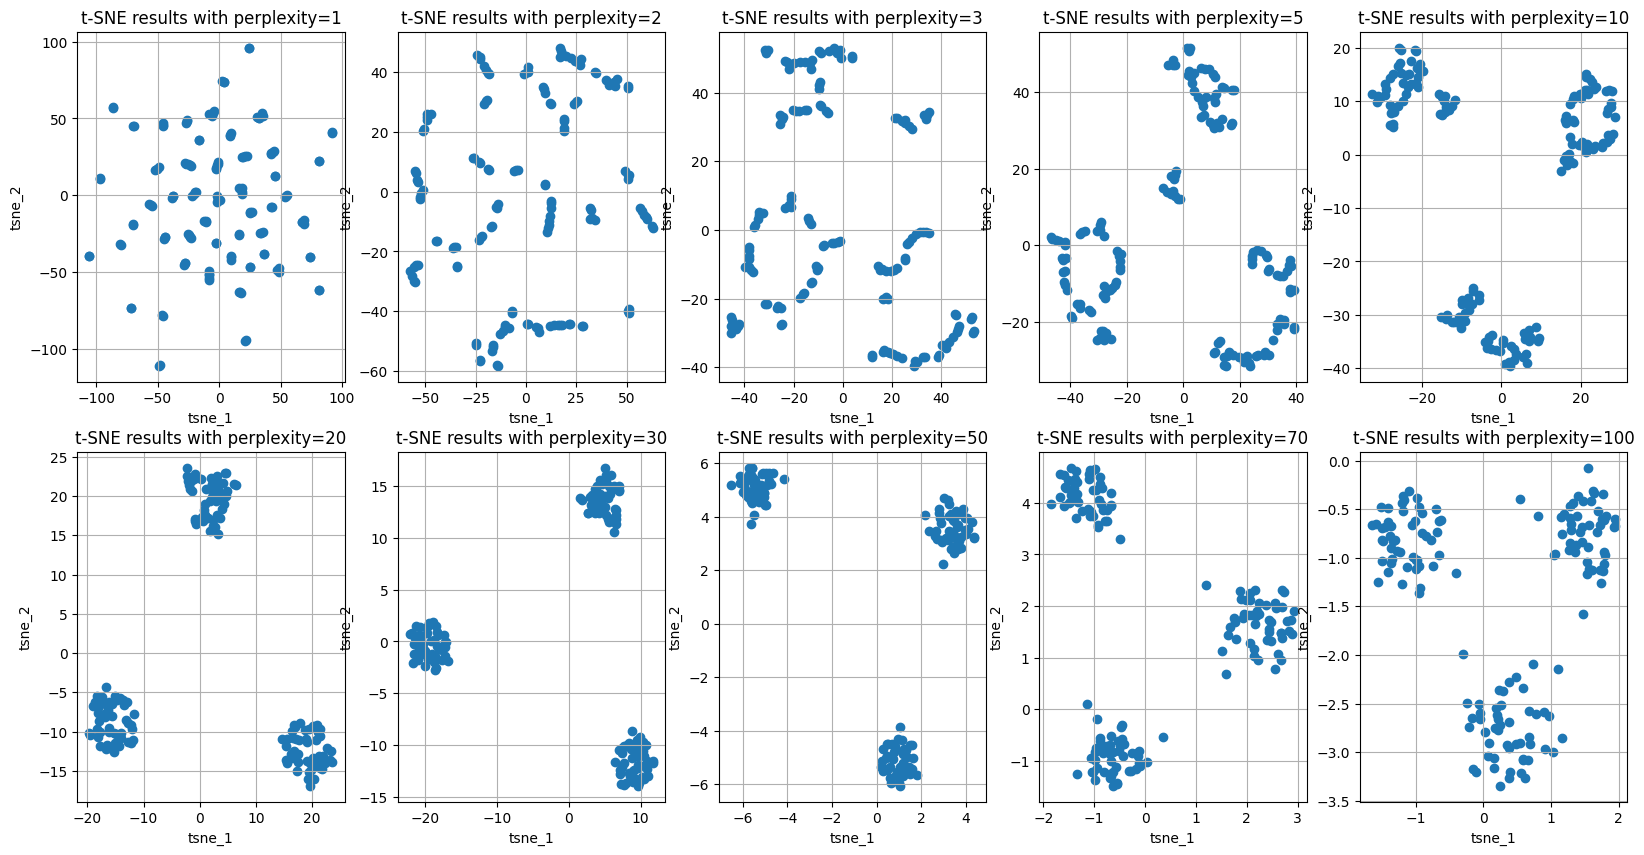

In [ ]:
def create_plot_with_given_perplexity_2d(perplexity: int, balls: pd.DataFrame, ax: plt.axes) -> None:
    tnse_2_dim = TSNE(n_components=2, init='random', random_state=42, learning_rate='auto', perplexity=perplexity)
    tnse_results = tnse_2_dim.fit_transform(balls)

    # plot the t-SNE results
    tse_result_df = pd.DataFrame(tnse_results, columns=['x', 'y'])
    ax.set_title(f"t-SNE results with perplexity={perplexity}")
    ax.scatter(tse_result_df['x'], tse_result_df['y'])
    ax.set_xlabel("tsne_1")
    ax.set_ylabel("tsne_2")
    ax.grid(True)

# plot the t-SNE results for different perplexity values
perplexities = [1, 2, 3, 5, 10, 20, 30, 50, 70, 100]
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, perplexity in enumerate(perplexities):
    create_plot_with_given_perplexity_2d(perplexity, balls, axs[i//5, i%5])

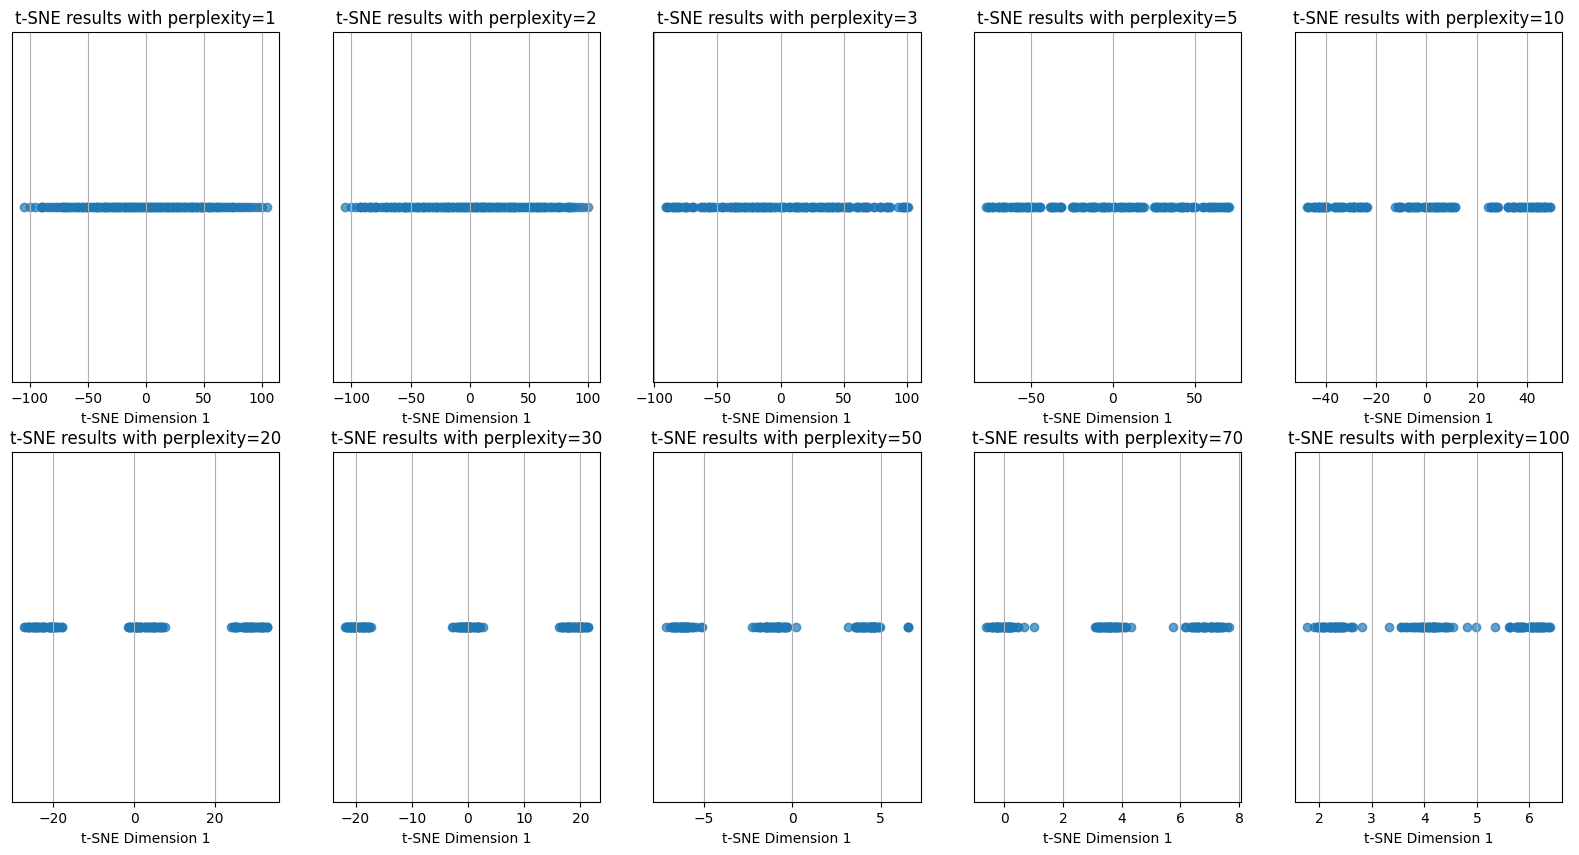

In [ ]:
def create_plot_with_given_perplexity_1d(perplexity: int, balls: pd.DataFrame, ax: plt.axes) -> None:
    tnse_1_dim = TSNE(n_components=1, init='random', random_state=42, learning_rate='auto', perplexity=perplexity)
    tnse_results = tnse_1_dim.fit_transform(balls.to_numpy())

    # Plot the t-SNE results
    tsne_result_df = pd.DataFrame(tnse_results, columns=['x'])
    ax.set_title(f"t-SNE results with perplexity={perplexity}")
    ax.scatter(tsne_result_df['x'], np.zeros_like(tsne_result_df['x']), alpha=0.7)
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_yticks([])
    ax.grid(True)

# plot the t-SNE results for different perplexity values
perplexities = [1, 2, 3, 5, 10, 20, 30, 50, 70, 100]
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

for i, perplexity in enumerate(perplexities):
    create_plot_with_given_perplexity_1d(perplexity, balls, axs[i // 5, i % 5])

#### Conclusions 
- when the perplexity is too low, we cannot distinguish different clusters.
- the same happens when the perplexity is too high.
- high and low perplexity values, when reducing to one dimension, produce worse results than in two dimensions.

# tSNE5 : MNIST data

(a) Study the convergence of the algorithm:
Set the perplexity to 25 and try the following values for the maximum number of iterations: 50, 100, 200, 400, 750, 1000. 

Visualize the result for each choice. Is the standard setting (which is 1000) enough? Can one assess convergence based on a single run?


(b) Perplexity determination: Try several values. Visualize the results and choose one.

(c) Assess stability: Perform 4 runs with the chosen perplexity. How stable is the result? Why does one get different results for each run?


In [297]:
# load dataset
minst_data = pd.read_csv('MnistN1000.csv')
labels = pd.read_csv('MNISTlabels.csv')
minst_data['label'] = labels

minst_data.head()

0  0.1  0.3  0.5  0.7  0.8  0.9  0.10  0.11  0.12  ...  0.651  0.652  \
0  0    0    0    0    0    0    0     0     0     0  ...      0      0   
1  0    0    0    0    0    0    0     0     0     0  ...      0      0   
2  0    0    0    0    0    0    0     0     0     0  ...      0      0   
3  0    0    0    0    0    0    0     0     0     0  ...      0      0   
4  0    0    0    0    0    0    0     0     0     0  ...      0      0   

   0.653  0.654  0.655  0.656  0.657  0.658  0.659  label  
0      0      0      0      0      0      0      0      5  
1      0      0      0      0      0      0      0     10  
2      0      0      0      0      0      0      0      1  
3      0      0      0      0      0      0      0      7  
4      0      0      0      0      0      0      0     10  

[5 rows x 785 columns]

#### a) testing different values of max_iter

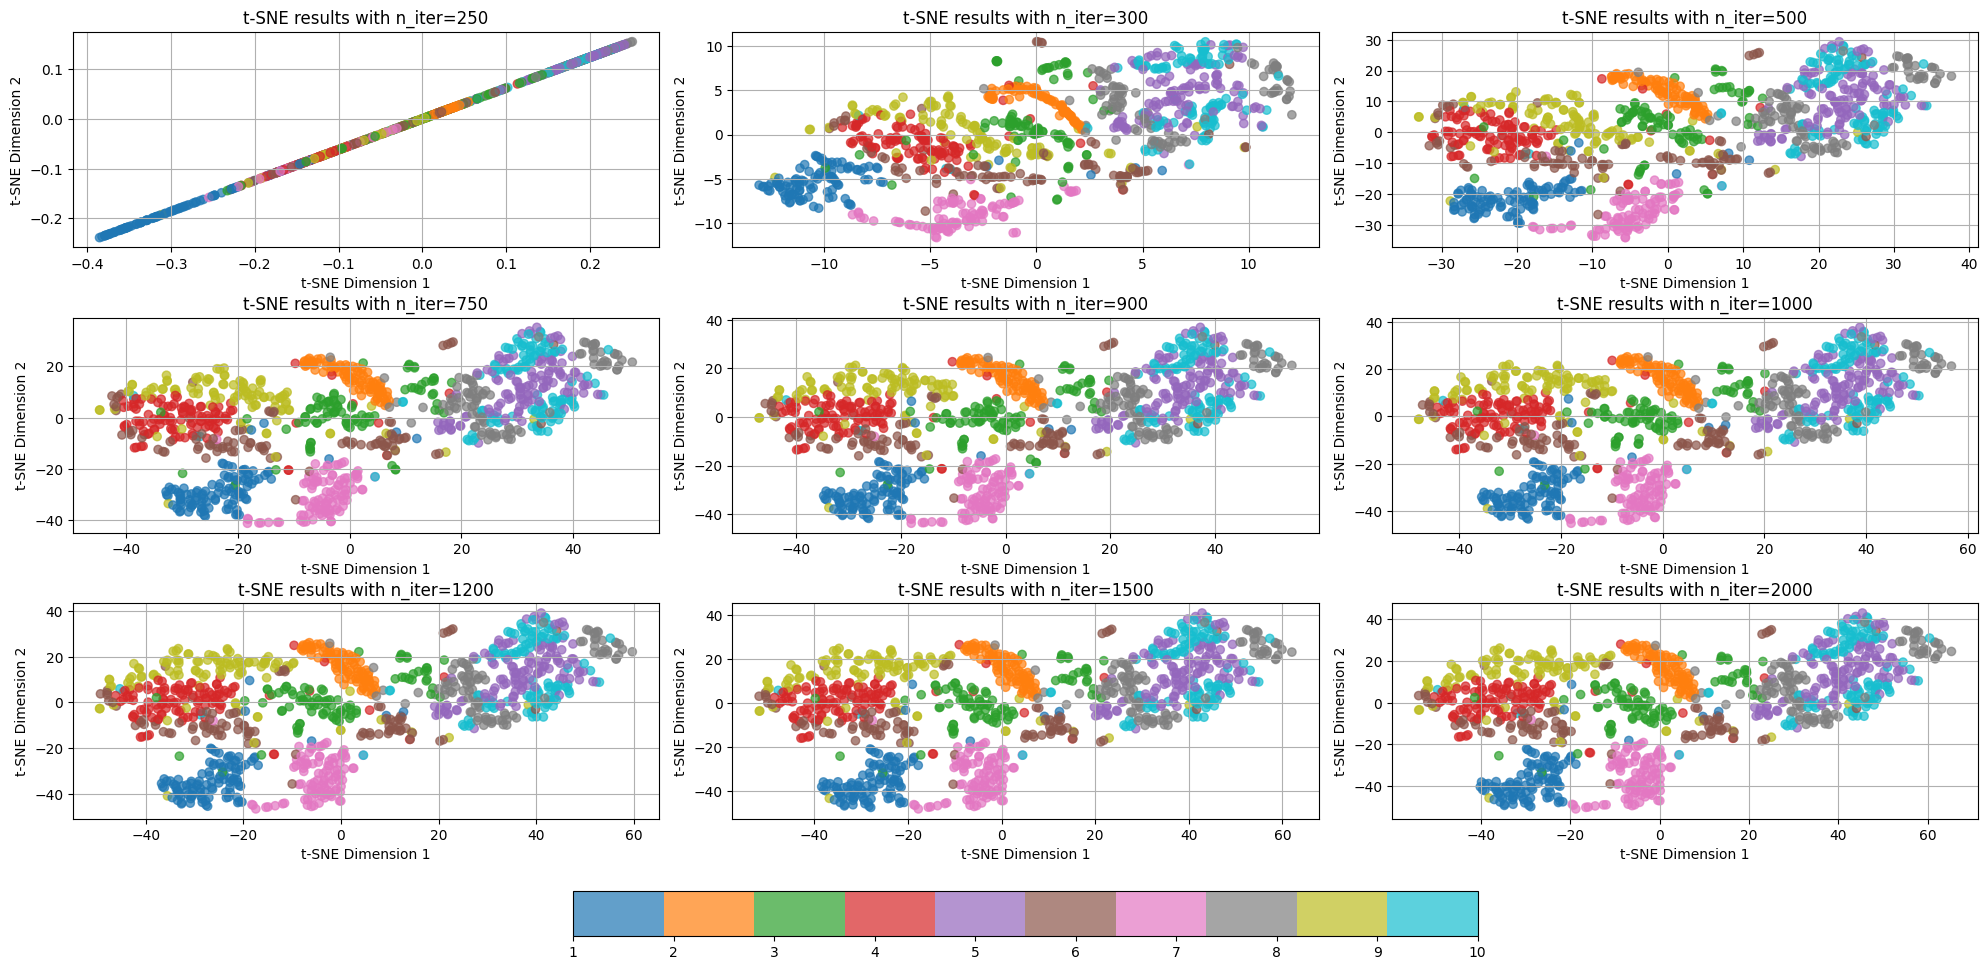

In [305]:
iterations = [250, 300, 500, 750, 900, 1000, 1200, 1500, 2000]
fig, ax = plt.subplots(3, 3, figsize=(20, 10))
ax = ax.flatten()

for index, n_iter in enumerate(iterations):

    tnse = TSNE(n_components=2, init='random', random_state=42, learning_rate='auto', max_iter=n_iter, perplexity=25)
    tnse_results = tnse.fit_transform(minst_data.drop(columns=['label']).to_numpy())

    # createa dataframe
    tsne_result_df = pd.DataFrame(tnse_results, columns=['x', 'y'])
    tsne_result_df['label'] = minst_data['label']

    # plot
    scatter = ax[index].scatter(
        tsne_result_df['x'],
        tsne_result_df['y'],
        c=tsne_result_df['label'],
        cmap='tab10',
        alpha=0.7
    )
    ax[index].set_title(f"t-SNE results with n_iter={n_iter}")
    ax[index].set_xlabel("t-SNE Dimension 1")
    ax[index].set_ylabel("t-SNE Dimension 2")
    ax[index].grid(True)

# adjust the layout
plt.tight_layout()

# add colorbar
fig.colorbar(scatter, ax=ax, orientation="horizontal", fraction=0.05, pad=0.08)

plt.show()


#### WARNING
- when i tried to set max_iter below 250 i got error
- after max_iter bigger than 1000 we cannot see any improvement

#### b) testing diffrent_values of perplexity

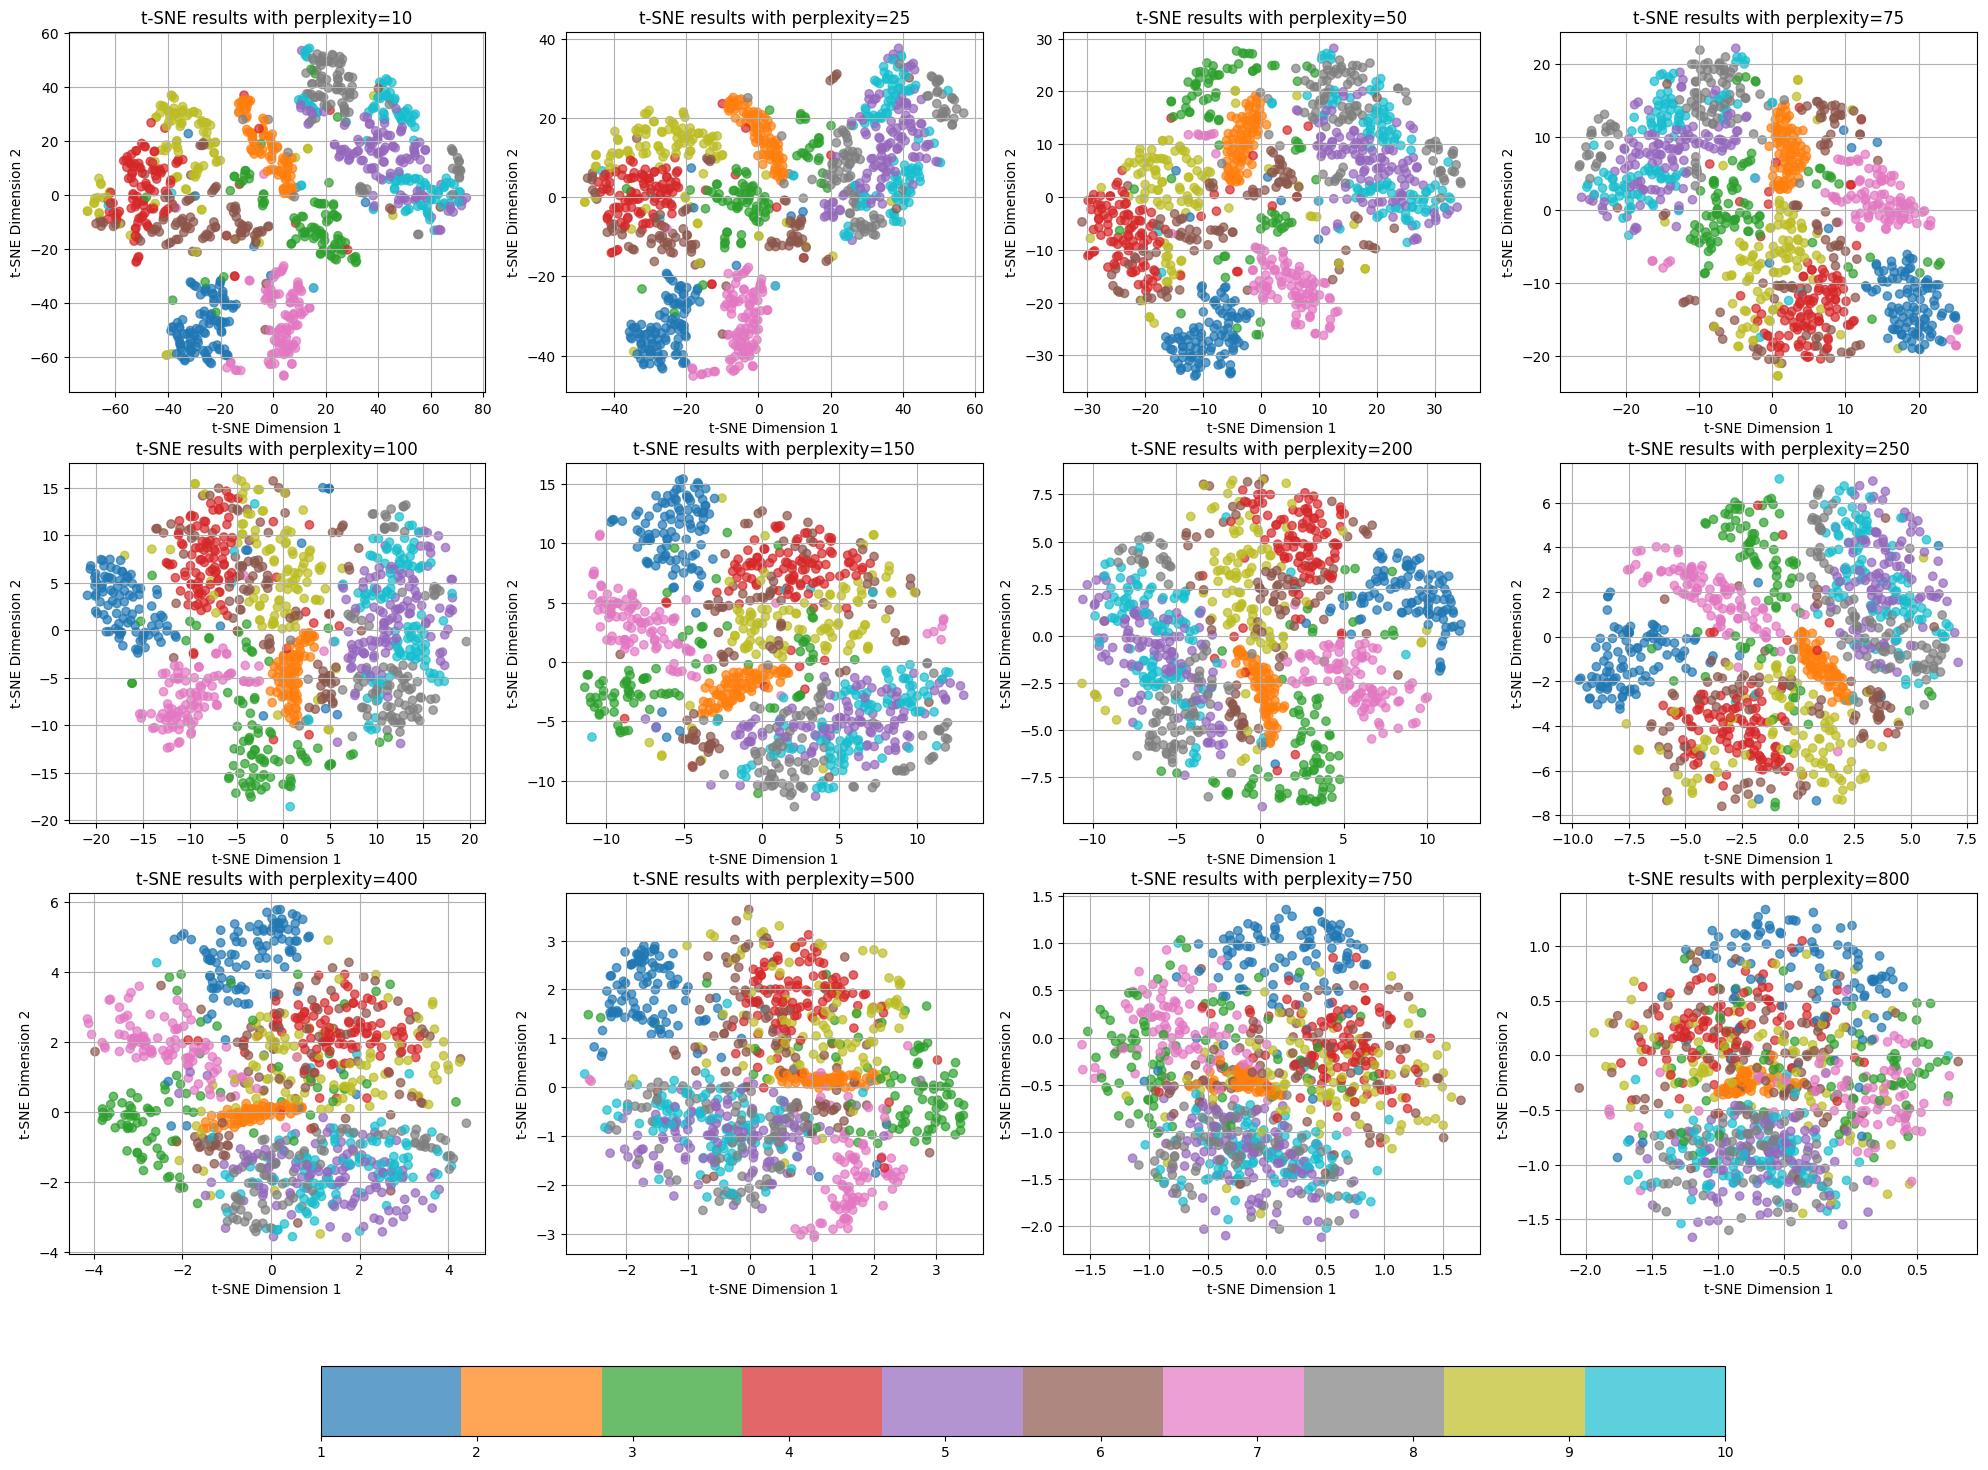

In [310]:
perplexities = [10, 25, 50, 75, 100, 150, 200, 250, 400, 500, 750, 800]

fig, ax = plt.subplots(3, 4, figsize=(20, 15))
ax = ax.flatten()

for index, perplexity in enumerate(perplexities):
    tnse = TSNE(n_components=2, init='random', random_state=42, learning_rate='auto', max_iter=1000, perplexity=perplexity)
    tnse_results = tnse.fit_transform(minst_data.drop(columns=['label']).to_numpy())

    # createa dataframe
    tsne_result_df = pd.DataFrame(tnse_results, columns=['x', 'y'])
    tsne_result_df['label'] = minst_data['label']

    # plot
    scatter = ax[index].scatter(
        tsne_result_df['x'],
        tsne_result_df['y'],
        c=tsne_result_df['label'],
        cmap='tab10',
        alpha=0.7
    )
    ax[index].set_title(f"t-SNE results with perplexity={perplexity}")
    ax[index].set_xlabel("t-SNE Dimension 1")
    ax[index].set_ylabel("t-SNE Dimension 2")
    ax[index].grid(True)

# adjust the layout
plt.tight_layout()

# add colorbar
fig.colorbar(scatter, ax=ax, orientation="horizontal", fraction=0.05, pad=0.08)

plt.show()

#### c) testing assess stability

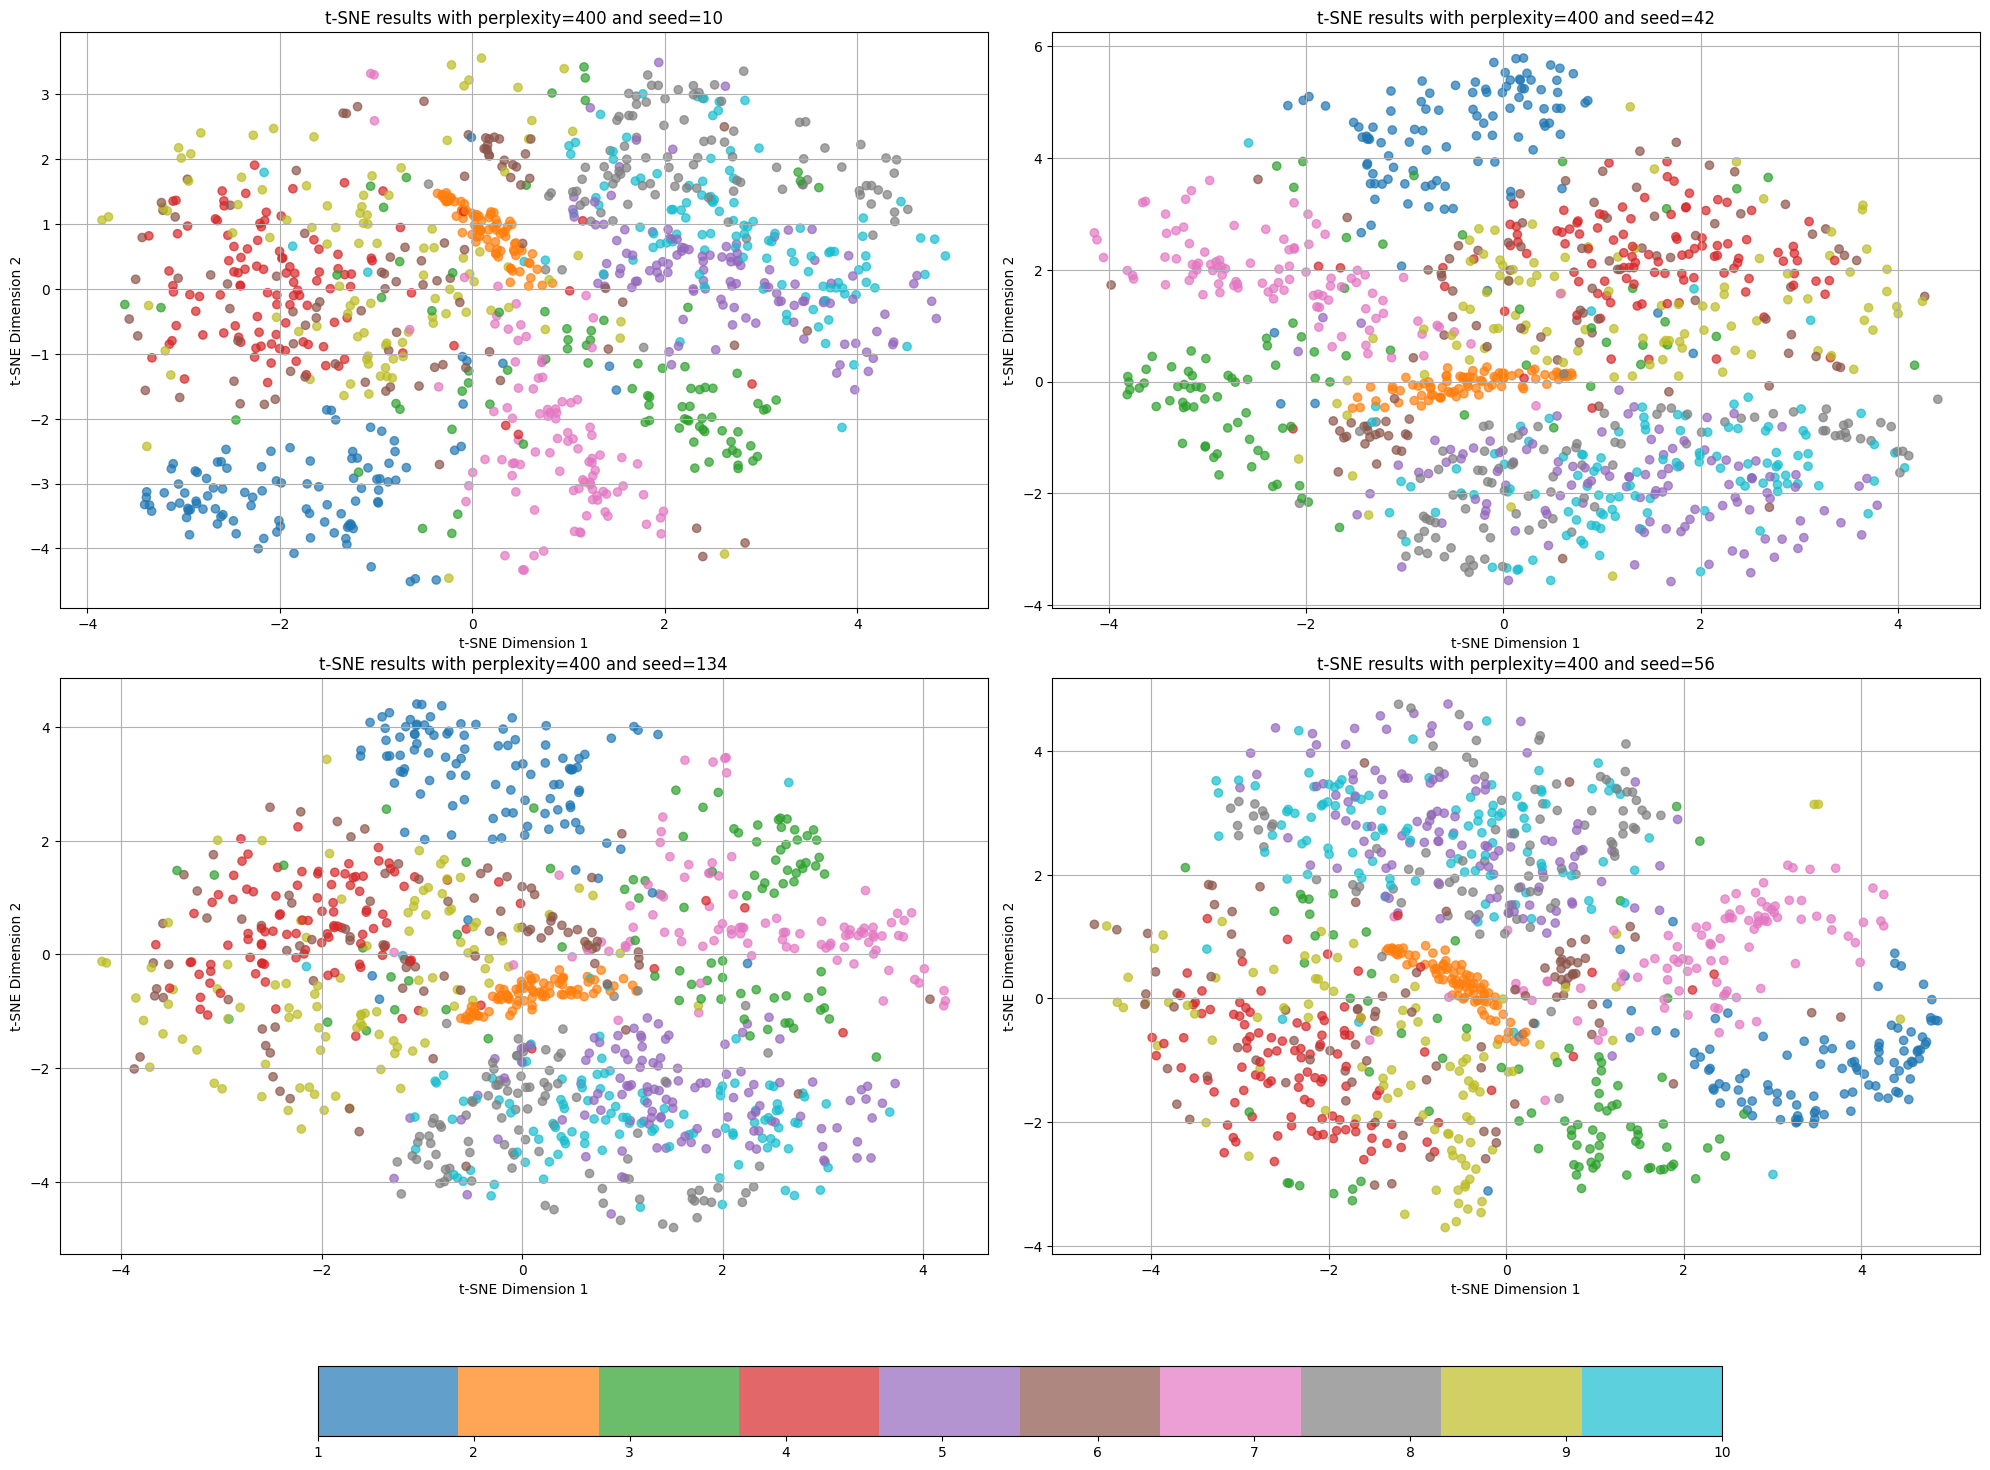

In [312]:
random_seeds = [10, 42, 134, 56]
chosen_perplexity = 400

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax = ax.flatten()

for index, seed in enumerate(random_seeds):
    tnse = TSNE(n_components=2, init='random', random_state=seed, learning_rate='auto', max_iter=1000, perplexity=chosen_perplexity)
    tnse_results = tnse.fit_transform(minst_data.drop(columns=['label']).to_numpy())

    # createa dataframe
    tsne_result_df = pd.DataFrame(tnse_results, columns=['x', 'y'])
    tsne_result_df['label'] = minst_data['label']

    # plot
    scatter = ax[index].scatter(
        tsne_result_df['x'],
        tsne_result_df['y'],
        c=tsne_result_df['label'],
        cmap='tab10',
        alpha=0.7
    )
    ax[index].set_title(f"t-SNE results with perplexity={chosen_perplexity} and seed={seed}")
    ax[index].set_xlabel("t-SNE Dimension 1")
    ax[index].set_ylabel("t-SNE Dimension 2")
    ax[index].grid(True)

# adjust the layout
plt.tight_layout()

# add colorbar
fig.colorbar(scatter, ax=ax, orientation="horizontal", fraction=0.05, pad=0.08)

plt.show()

- t-SNE starts with a random initialization of points in the embedding space.
- this initialization directly influences how the optimization process proceeds because t-SNE minimizes a non-convex loss function.
- different random seeds result in different initial positions, which can lead to different final configurations due to the algorithm's sensitivity to initial conditions.
- t-SNE aims to preserve local structures (clusters), but how it organizes clusters spatially can vary based on the random initialization.
- for example, one run might place two clusters close together, while another run may separate them slightly differently.

# tSNE6 :  Movies data

(a) Perplexity determination: Try several values. Visualize the results and choose one.

(b) Cluster your reduced data using kmeans with a good selection of k. Describe the resulting cluster centers. Can you transform them back to the original space?

#### Loading the data

In [4]:
movie_data = pd.read_csv('movieData.csv')
movie_data.head()

Row  Action  Adult  \
0                               "#7DaysLater" (2013)       0      0   
1       "#BlackLove" (2015) {Crash the Party (#1.9)}       0      0   
2  "#BlackLove" (2015) {Making Lemonade Out of Le...       0      0   
3      "#BlackLove" (2015) {Miss Independent (#1.5)}       0      0   
4     "#BlackLove" (2015) {Sealing the Deal (#1.10)}       0      0   

   Adventure  Animation  Biography  Comedy  Crime  Documentary  Drama  ...  \
0          0          0          0       1      0            0      0  ...   
1          0          0          0       0      0            0      0  ...   
2          0          0          0       0      0            0      0  ...   
3          0          0          0       0      0            0      0  ...   
4          0          0          0       0      0            0      0  ...   

   News  RealityTV  Romance  SciFi  Short  Sport  TalkShow  Thriller  War  \
0     0          0        0      0      0      0         0         0    0   
1     0          1        0      0      0      0         0         0    0   
2     0          1        0      0      0      0         0         0    0   
3     0          1        0      0      0      0         0         0    0   
4     0          1        0      0      0      0         0         0    0   

   Western  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 29 columns]

In [6]:
movie_data.shape

(49999, 29)

#### a) Perplexity determination

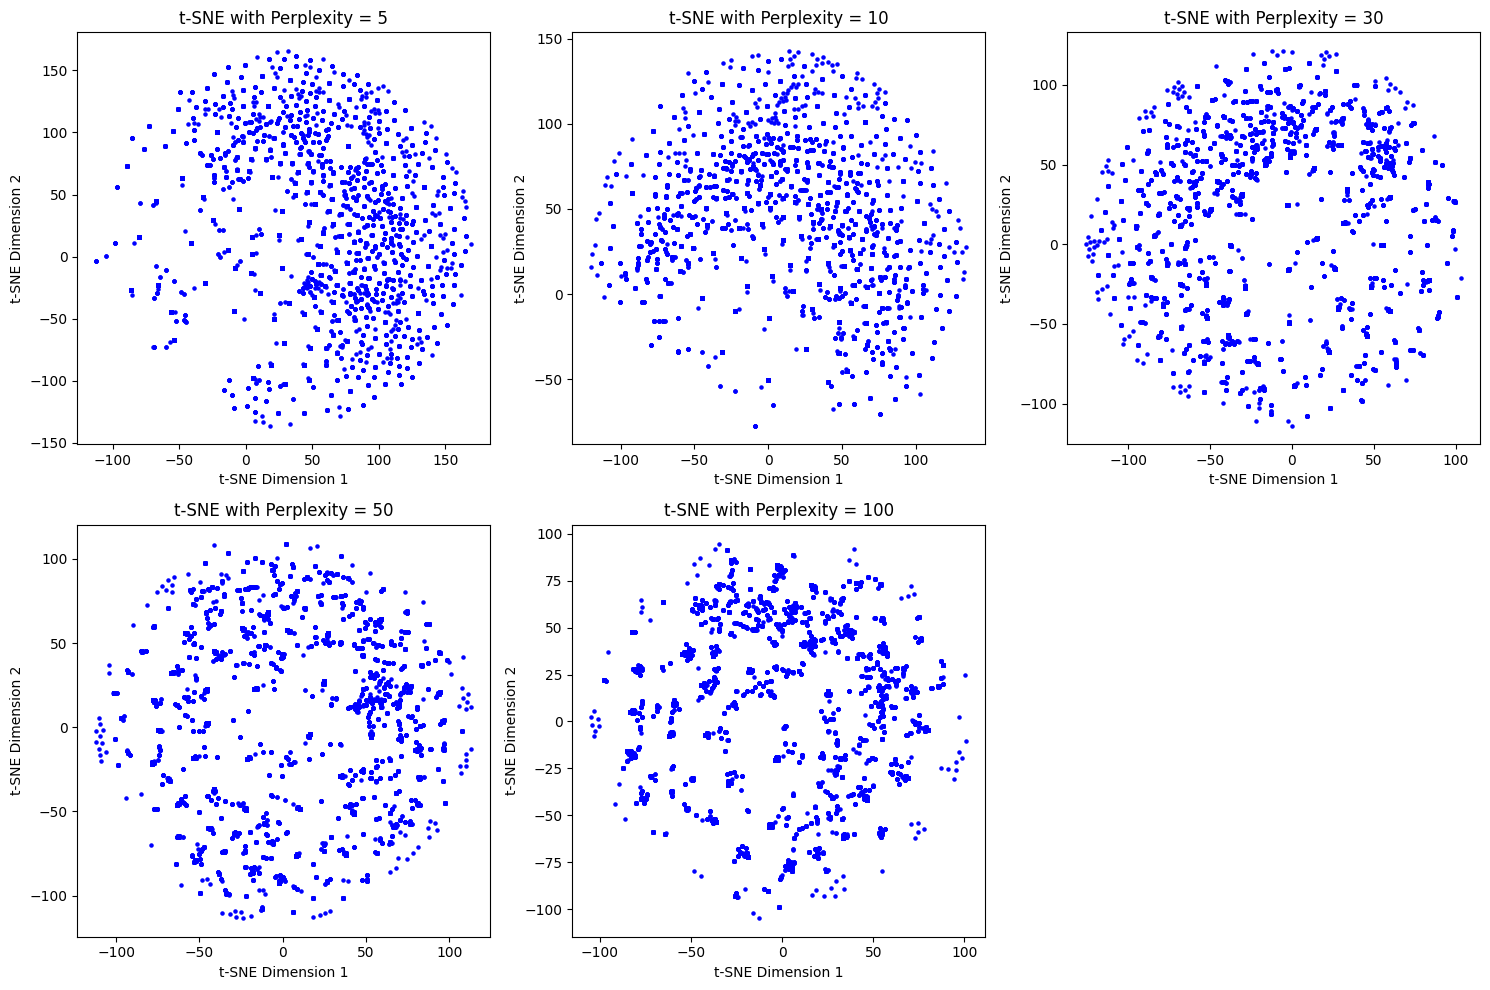

In [ ]:
genres = movie_data.iloc[:, 2:]

perplexities = [5, 10, 30, 50, 100]
tsne_results = {}

plt.figure(figsize=(15, 10))
for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_results[perplexity] = tsne.fit_transform(genres)

    plt.subplot(2, 3, i + 1)
    plt.scatter(tsne_results[perplexity][:, 0], tsne_results[perplexity][:, 1], s=5, c='blue')
    plt.title(f't-SNE with Perplexity = {perplexity}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

I would say that the best results are for the perplexity 100

#### b) KMeans

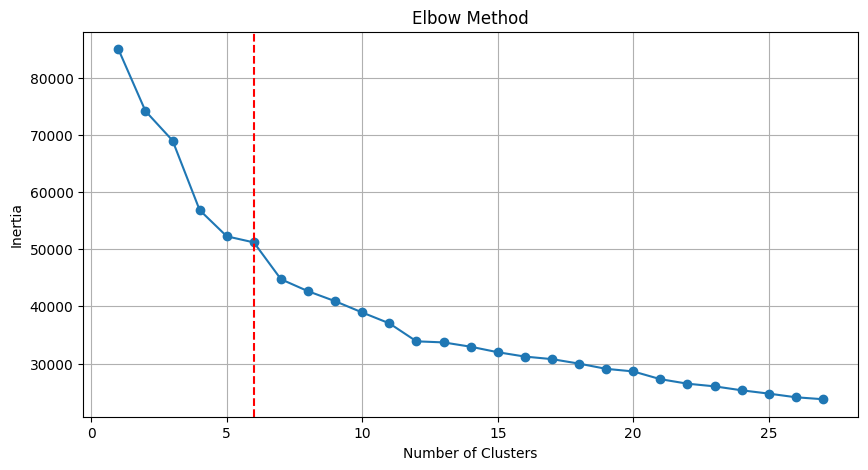

In [20]:
# selecting k by the elbow method
inertia = []

data = movie_data.copy()
data_genres = data.iloc[:, 2:]

k_values = range(1, 28)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_genres)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.axvline(6, color='red', linestyle='--')
plt.grid(True)


In [ ]:
best_perplexity = 100
reduced_data = tsne_results[best_perplexity]

optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# analyze cluster centers
cluster_centers_reduced = kmeans.cluster_centers_

# transform back to original space by calculating mean genre values for each cluster
movie_data['Cluster'] = clusters
numeric_columns = movie_data.select_dtypes(include=[np.number]).columns
cluster_profiles = movie_data.groupby('Cluster')[numeric_columns].mean()

# print the genre profile of each cluster
print(cluster_profiles)

           Action     Adult  Adventure  Animation  Biography    Comedy  \
Cluster                                                                  
0        0.012780  0.000000   0.075338   0.003916   0.010409  0.058745   
1        0.115074  0.000273   0.024327   0.003280   0.079541  0.000137   
2        0.158452  0.000181   0.168852   0.364475   0.001537  0.739803   
3        0.098734  0.000283   0.099017   0.089475   0.006425  0.388889   
4        0.006055  0.000000   0.045819   0.000491   0.001964  0.004746   
5        0.270710  0.000574   0.038645   0.021619   0.002870  0.044959   

            Crime  Documentary     Drama    Family  ...  RealityTV   Romance  \
Cluster                                             ...                        
0        0.016902     0.009894  0.000721  0.137895  ...   0.456251  0.005565   
1        0.293563     0.128195  0.777094  0.002050  ...   0.000410  0.046877   
2        0.018631     0.001990  0.011395  0.339785  ...   0.007687  0.107895   
3      

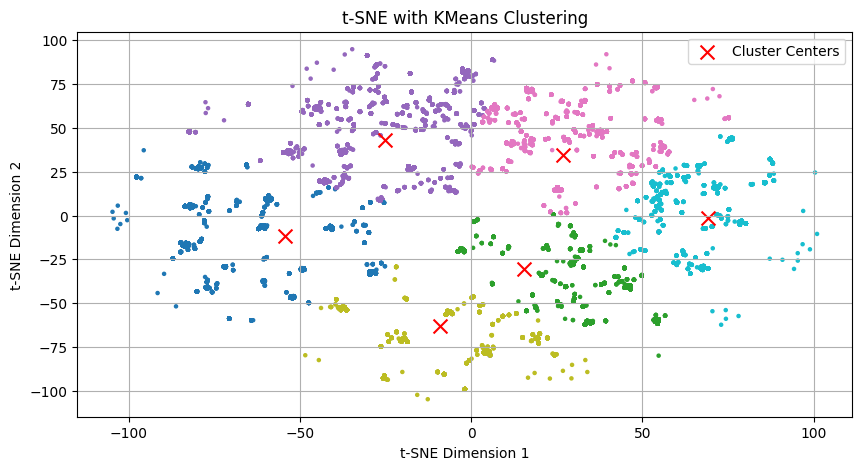

In [31]:
# plot the clusters
plt.figure(figsize=(10, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='tab10', s=5)
plt.title('t-SNE with KMeans Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# plot the cluster centers
plt.scatter(cluster_centers_reduced[:, 0], cluster_centers_reduced[:, 1], c='red', s=100, marker='x', label='Cluster Centers')
plt.legend()
plt.grid(True)
plt.show()